In [83]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys
from sklearn.model_selection import train_test_split # train , test 분리에 사용.

from tqdm import trange
import random


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [84]:
from tqdm import tqdm

# 데이터 전처리

```

TurbID - 발전기 ID

Day - 날짜

Tmstamp - 시간

Wspd - 풍속

Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이

Etmp - 외부 온도

Itmp - 터빈 내부 온도

Ndir - 터빈이 바라보는 방향 각도

Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름

Prtv - 무효전력 : 에너지원을 필요로 하지 않는 전력

Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력

````


베이스 라인 제공 전처리 방법

In [131]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [132]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [133]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
train_data = train_data.fillna(method = 'ffill').fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64


In [134]:
train_data[(train_data["TurbID"]==1)&(train_data["Day"]==1)]

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1,1,23:10,9.95,0.49,28.71,42.53,-9.44,1.02,1.02,1.02,-0.29,1330.24
140,1,1,23:20,12.20,0.70,28.59,42.56,-8.17,1.08,1.08,1.08,-0.23,1550.74
141,1,1,23:30,12.66,1.09,28.54,42.23,-8.17,1.08,1.08,1.08,-0.21,1549.66
142,1,1,23:40,12.58,1.70,28.48,42.09,-8.17,1.08,1.08,1.08,-0.20,1549.64


In [135]:
train_data=train_data[(train_data["TurbID"]==21)]

# 데이터셋

In [136]:
# 한 Turb당 194 line
# label은 2일.로 나눠야함.

def make_train_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(1, 195): # 1~195 (1~194까지?)
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+ 5)]
            label_day_list = [y for y in range(j+5, j + 6)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]
            label_tmp = label_tmp.drop(["TurbID", "Day","Patv"], axis = 1)
            
            # feature 선택 및 제거
            #train_tmp = train_tmp["Wspd"]
            train_tmp = train_tmp.drop(["TurbID", "Day","Patv"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y



In [137]:
# time stamp label encoding
tms_list = list(pd.unique(train_data["Tmstamp"]))
train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x) )
train_data["Tmstamp"] = train_data["Tmstamp"]//6

In [92]:
train_data[0:+6]

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
576000,21,1,0,3.07,-2.56,8.18,23.20,223.45,0.01,0.01,0.01,-77.64,157.50
576001,21,1,0,5.46,-10.18,31.62,42.59,170.92,0.35,0.35,0.35,-0.08,293.28
576002,21,1,0,5.11,-10.16,31.58,42.74,170.92,0.06,0.06,0.05,-0.04,268.40
576003,21,1,0,4.80,-2.57,31.47,42.77,160.98,0.09,0.09,0.09,-0.07,252.73
576004,21,1,0,4.74,1.37,31.31,42.54,158.40,0.03,0.03,0.03,-0.07,253.02
576005,21,1,0,4.55,1.31,31.25,42.37,158.40,0.03,0.03,0.02,-0.07,229.24


In [138]:
my_df=train_data.groupby(['Day','Tmstamp']).max()
my_df

TurbID  Wspd   Wdir   Etmp   Itmp    Ndir  Pab1  Pab2  Pab3  \
Day Tmstamp                                                                
1   0            21  5.46   1.37  31.62  42.77  223.45  0.35  0.35  0.35   
    1            21  4.85   4.53  31.16  42.19  158.40  0.03  0.03  0.03   
    2            21  5.87  10.23  30.27  41.56  149.57  0.91  0.91  0.91   
    3            21  5.49   8.59  29.90  40.57  133.35  1.57  1.57  1.57   
    4            21  7.43   3.23  29.79  40.66  133.35  8.38  8.38  8.38   
...             ...   ...    ...    ...    ...     ...   ...   ...   ...   
200 19           21  5.13   4.35  13.51  23.09  343.81  0.01  0.01  0.01   
    20           21  5.10  -0.88  13.22  23.06  347.04  0.01  0.01  0.01   
    21           21  6.26   3.29  12.34  22.59  345.06  0.01  0.01  0.01   
    22           21  5.03   2.23  12.50  22.63  346.12  0.01  0.01  0.01   
    23           21  4.66   2.31  12.15  22.72  345.07  0.01  0.01  0.01   

              Prtv    Patv  
Day Tmstamp                 
1   0        -0.04  293.28  
    1        -0.01  266.07  
    2        -0.07  403.66  
    3        -0.05  375.84  
    4        -0.05  356.13  
...            ...     ...  
200 19       -1.91  352.17  
    20        9.59  352.25  
    21      -43.13  574.29  
    22      -70.43  330.97  
    23      -68.84  278.29  

[4800 rows x 11 columns]

In [139]:
my_df.reset_index(inplace=True)

In [140]:

X_data, Y_data = make_train_data(my_df)
#valid_x, valid_y = make_valid_data(train_data)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.33it/s]


In [141]:
X_data  = np.array(X_data).reshape(-1, X_data[0].shape[0], X_data[0].shape[1] )
#train_x = np.array(X_data)
Y_data = np.array(Y_data)

In [142]:
X_data.shape

(194, 120, 10)

In [143]:
#train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#valid_x = np.array(valid_x)
#valid_y = np.array(valid_y)

In [144]:
from sktime.forecasting.all import temporal_train_test_split

train_y, valid_y, train_x, valid_x = temporal_train_test_split(X=X_data,y=Y_data, test_size=0.1)

In [145]:
np.array(train_y).shape

(174, 24, 10)

In [146]:
train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
train_y = np.array(train_y)
print(train_x.shape, train_y.shape)

(174, 120, 10) (174, 24, 10)


In [147]:
valid_x  = np.array(valid_x).reshape(-1, valid_x[0].shape[0], valid_x[0].shape[1])
valid_y = np.array(valid_y)
print(valid_x.shape, valid_y.shape)

(20, 120, 10) (20, 24, 10)


input dimension은 (Batch, Time_step, Feature dimension) 순이다. (batch_first=True)

output이 288인 이유는 2일이라서

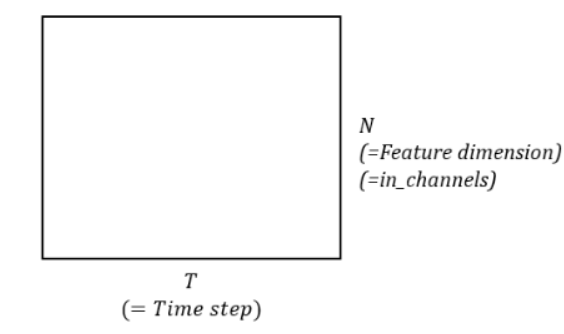

# 정규화

std norm 을 이용하고, inference 후 , 다시 복구 시킨다

In [148]:
global_mean=train_x.mean(axis=1).mean(axis=0)
global_std=train_x.std(axis=1).std(axis=0)

global_y_mean = train_y.mean(axis=1).mean(axis=0)
global_y_std = train_y.std(axis=1).std(axis=0)

train_x=(train_x-global_mean)/(global_std)
train_y=(train_y-global_y_mean)/(global_y_std)

valid_x=(valid_x-global_mean)/(global_std)
valid_y=(valid_y-global_y_mean)/(global_y_std)

# 데이터 로더

In [149]:
EPOCHS = 50
BATCH_SIZE = 128
lr = 1e-3
lstm_hidden_layer=256

In [150]:
from torch.utils.data import Dataset, DataLoader

class TimeDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        
        return torch.Tensor(self.X[index]) # 테스트셋 용
    


In [151]:
train_dataset = TimeDataset(train_x, train_y)
valid_dataset = TimeDataset(valid_x, valid_y)


train_loader = DataLoader(train_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(valid_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)



# 데이터 확인

In [152]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0].shape)


X_train :  torch.Size([128, 120, 10]) type: torch.FloatTensor
Y_train :  torch.Size([128, 24, 10]) type: torch.FloatTensor
torch.Size([24, 10])


In [153]:
#valiation set 확인
for (X_valid,Y_valid) in valid_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0].shape)

X_valid :  torch.Size([20, 120, 10]) type: torch.FloatTensor
Y_valid :  torch.Size([20, 24, 10]) type: torch.FloatTensor
torch.Size([24, 10])


# 모델


### input 설명

- input_size: input의 feature dimension을 넣어주어야 한다. time step이 아니라 feature dimension!
- hidden_size: 내부에서 어떤 feature dimension으로 바꿔주고 싶은지를 넣어주면 된다.
- num_layers: lstm layer를 얼마나 쌓을지
- bias: bias term을 둘 것인가 (Default: True)
- batch_first: batch가 0번 dimension으로 오게 하려면 이거 설정! 난 이거 설정 가정하고 설명했다. (Default: False)
- dropout: 가지치기 얼마나 할지, generalization 잘안되면 이걸 조정하면 된다.
bidirectional: 양방향으로 할지 말지 (bidirectional 하면 [forward, backword] 로 feature dimension 2배 됨)



참고.

https://sanghyu.tistory.com/52

### output 설명

- outputs는 (output, (hidden or hidden stat,cell stat)) 의 tuple 형태로 나오므로 주의해서 써야한다. (LSTM만 cell state있음)
- output: output dimension은 (batch, time_step, hidden dimension) 순이다. 양방향일 경우 hidden_size*2
- hidden state: 모든 layer의 hidden state를 담고있다.
- cell state: 모든 layer의 cell state를 담고있다.

In [110]:
lstm = nn.LSTM(input_size=10, hidden_size=256, batch_first=True, bidirectional=True)

lstm(X_valid)[0].size()

torch.Size([20, 120, 512])

In [26]:
lstm(X_valid)[0][-1].size()

torch.Size([720, 512])

In [27]:
lstm(X_valid)[1][0]

tensor([[[-0.0315, -0.0332,  0.0031,  ...,  0.0189,  0.0270,  0.0718],
         [-0.0477, -0.0012, -0.0040,  ..., -0.0098,  0.0318,  0.0364],
         [-0.0345, -0.0233,  0.0001,  ...,  0.0130,  0.0288,  0.0639],
         ...,
         [-0.0431, -0.0096, -0.0023,  ..., -0.0017,  0.0305,  0.0464],
         [-0.0281, -0.0374,  0.0037,  ...,  0.0249,  0.0269,  0.0784],
         [-0.0270, -0.0404,  0.0042,  ...,  0.0260,  0.0262,  0.0805]],

        [[-0.0145, -0.0258,  0.0397,  ...,  0.0021, -0.0511, -0.0364],
         [-0.0020, -0.0351,  0.0193,  ..., -0.0169, -0.0359, -0.0226],
         [-0.0093, -0.0297,  0.0308,  ..., -0.0061, -0.0446, -0.0304],
         ...,
         [-0.0123, -0.0279,  0.0351,  ..., -0.0023, -0.0486, -0.0331],
         [-0.0039, -0.0341,  0.0212,  ..., -0.0151, -0.0383, -0.0236],
         [-0.0179, -0.0229,  0.0460,  ...,  0.0079, -0.0551, -0.0406]]],
       grad_fn=<StackBackward0>)

In [28]:
lstm(X_valid)[0][:,-2,:].size()

torch.Size([20, 512])

In [154]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        #print(lstm_out.size())
        return lstm_out, self.hidden

In [49]:
lsenc=lstm_encoder(input_size=10, hidden_size=256)

In [50]:
X_valid.unsqueeze(2).size()

torch.Size([20, 120, 1, 10])

In [51]:

hidden=lsenc(X_valid)[1]

torch.Size([20, 120, 256])


In [33]:
hidden

(tensor([[[ 0.0018, -0.0125,  0.0657,  ...,  0.0003, -0.0122, -0.0141],
          [-0.0018, -0.0053,  0.0389,  ..., -0.0061, -0.0550,  0.0049],
          [ 0.0021, -0.0115,  0.0588,  ...,  0.0006, -0.0226, -0.0109],
          ...,
          [-0.0009, -0.0071,  0.0463,  ..., -0.0042, -0.0431, -0.0006],
          [ 0.0040, -0.0151,  0.0698,  ...,  0.0030, -0.0047, -0.0186],
          [ 0.0034, -0.0148,  0.0722,  ...,  0.0029, -0.0020, -0.0191]]],
        grad_fn=<StackBackward0>),
 tensor([[[ 0.0034, -0.0248,  0.1317,  ...,  0.0005, -0.0247, -0.0292],
          [-0.0035, -0.0107,  0.0773,  ..., -0.0113, -0.1107,  0.0099],
          [ 0.0040, -0.0228,  0.1177,  ...,  0.0012, -0.0457, -0.0225],
          ...,
          [-0.0016, -0.0143,  0.0923,  ..., -0.0079, -0.0868, -0.0012],
          [ 0.0075, -0.0299,  0.1402,  ...,  0.0059, -0.0095, -0.0387],
          [ 0.0063, -0.0294,  0.1451,  ...,  0.0055, -0.0040, -0.0397]]],
        grad_fn=<StackBackward0>))

In [155]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        #print(x_input.size())
        lstm_out, self.hidden = self.lstm(x_input, encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

In [53]:
X_valid[:,-1,:].unsqueeze(1).shape

torch.Size([20, 1, 10])

In [56]:
hidden[0]

tensor([[[ 0.7616, -0.7616,  0.0000,  ..., -0.7616,  0.7616,  1.0000],
         [ 0.7616, -0.7616,  0.0000,  ..., -0.7616,  0.7616,  1.0000],
         [ 0.7616, -0.7616,  0.0000,  ..., -0.7616,  0.7616,  1.0000],
         ...,
         [ 0.7616, -0.7616,  0.0000,  ..., -0.7616,  0.7616,  1.0000],
         [ 0.7616, -0.7616,  0.0000,  ..., -0.7616,  0.7616,  1.0000],
         [ 0.7616, -0.7616,  0.0000,  ..., -0.7616,  0.7616,  1.0000]]],
       grad_fn=<StackBackward0>)

In [37]:
X_valid[:,-1,:].shape

torch.Size([20, 1])

In [59]:
X_valid.size()

torch.Size([20, 120, 10])

In [62]:
lsde = lstm_decoder(input_size=10, hidden_size=256)

lsde(X_valid , hidden)


torch.Size([20, 120, 10])

In [156]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size).to(DEVICE)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input.unsqueeze(-2), hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :].squeeze()
            else:
                decoder_input = out
            outputs[:,t,:] = out
        
        return outputs.squeeze()

    def predict(self, inputs, target_len):
        inputs = inputs
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size).to(DEVICE)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs[:,:,0]

In [126]:
X_valid.size()

torch.Size([20, 120, 10])

In [127]:
Y_valid.unsqueeze(-1).size()

torch.Size([20, 24, 10, 1])

In [42]:
lsed=lstm_encoder_decoder(1,256)
lsed(inputs=X_valid,targets=Y_valid.unsqueeze(-1), target_len=288, teacher_forcing_ratio=0.6).size()

## 11 ->1 이 되도록 수정이 필요하다.

torch.Size([20, 288])

In [177]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=11, hidden_size=256, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512,512),# 사이즈는 hidden size에 따라 결정.
            nn.ReLU(),
            nn.Linear(512,288), #결과 288개 예측.
            nn.ReLU(),  
        )
        
    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.classifier(output[:,-1,:]) # -1은 hidden state의 마지막 time step값을 가져온 것.
        return output

In [157]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    train_loss = 0
    train_mae_loss = 0
    for batch_idx,(X, Y) in enumerate(train_loader):
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)

        optimizer.zero_grad()#데이터들 장비에 할당
        output = model(inputs=X, targets=Y.unsqueeze(-1),target_len=24, teacher_forcing_ratio=0.6) # model로 output을 계산
        loss = criterion(output, Y)        
        train_loss += loss.item()
        
        with torch.no_grad():
            mae = metric(output, Y)
            train_mae_loss+=mae.item()
        loss.backward()
        optimizer.step()
    
    #train_loss/=len(train_loader.dataset)
    #train_mae_loss/=len(train_loader.dataset)
    
    return train_loss,train_mae_loss



In [158]:
#8. 학습
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    valid_mae = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for X, Y in valid_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            output = model(inputs=X,targets=Y.unsqueeze(-1),target_len=24, teacher_forcing_ratio=0.6) # model로 output을 계산
            loss = criterion(output, Y)
            valid_loss += loss.item()
            mae = metric(output, Y)
            valid_mae+=mae.item()
        
    #valid_loss/=len(valid_loader.dataset)
    #valid_mae/=len(valid_loader.dataset)
    return valid_loss, valid_mae


In [159]:
#학습 진행 코드


check_path = './checkpoint/checkpoint_seq2seq_onecol.pt'
print(check_path)
model = lstm_encoder_decoder(input_size=10,hidden_size=lstm_hidden_layer).to(DEVICE)
criterion = nn.MSELoss().to(DEVICE)
metric = nn.L1Loss().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(),lr=lr)

best_valid_mae = 999999
best_valid_loss = 9999999999



for Epoch in range(1,EPOCHS+1):
    train_loss,train_mae = train(model,train_loader,optimizer,log_interval=31)
    valid_loss,valid_mae = evaluate(model, valid_loader)
    
    
    print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train MAE:{:.4f}  | \tValid Loss:{:.4f} \tValid MAE: {:.4f}\n".
                  format(Epoch, train_loss, train_mae,
                         valid_loss, valid_mae ))
    if best_valid_loss > valid_loss:
        print("-- SAVE Checkpoint --")
        print("Valid loss : {:.4f} -> {:.4f} \n".format(best_valid_loss,valid_loss ))
        torch.save(model.state_dict(), check_path, _use_new_zipfile_serialization=False)
        best_valid_mae = valid_mae
        best_valid_loss =valid_loss
        
    
    

./checkpoint/checkpoint_seq2seq_onecol.pt

[EPOCH:1]	 Train Loss:3037079764534436210190713880576.0000	 Train MAE:675539970949120.0000  | 	Valid Loss:1518539882267218105095356940288.0000 	Valid MAE: 337769985474560.0000


[EPOCH:2]	 Train Loss:3037079764534436210190713880576.0000	 Train MAE:675539970949120.0000  | 	Valid Loss:1518539882267218105095356940288.0000 	Valid MAE: 337769985474560.0000


[EPOCH:3]	 Train Loss:3037079764534436210190713880576.0000	 Train MAE:675539970949120.0000  | 	Valid Loss:1518539882267218105095356940288.0000 	Valid MAE: 337769985474560.0000


[EPOCH:4]	 Train Loss:3037079764534436210190713880576.0000	 Train MAE:675539970949120.0000  | 	Valid Loss:1518539882267218105095356940288.0000 	Valid MAE: 337769985474560.0000


[EPOCH:5]	 Train Loss:3037079764534436210190713880576.0000	 Train MAE:675539970949120.0000  | 	Valid Loss:1518539882267218105095356940288.0000 	Valid MAE: 337769985474560.0000


[EPOCH:6]	 Train Loss:3037079764534436210190713880576.0000	 Train M


[EPOCH:50]	 Train Loss:3037079764534436210190713880576.0000	 Train MAE:675539970949120.0000  | 	Valid Loss:1518539882267218105095356940288.0000 	Valid MAE: 337769985474560.0000



In [47]:
dddd

NameError: name 'dddd' is not defined

# validation 확인

In [79]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

Valid loss : 0.2043 / Valid MAE : 0.3411 



In [35]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

Valid loss : 0.2425 / Valid MAE : 0.3903 



# TEST

In [80]:

# 이전 5일치 가져오기.
test_data_list = [x for x in range(95, 100)]

test_data = my_df[my_df["Day"].isin(test_data_list)]

#test_data = test_data.drop(["TurbID", "Day"], axis = 1)
test_data = test_data['Wspd']

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0],1)
#train set 처럼 batch,720,11로 고치기


In [81]:
test_data.shape

(1, 120, 1)

In [82]:
test_dataset = TimeDataset(test_data, None)

test_loader = DataLoader(test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)




In [83]:
def predict(model, test_loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(DEVICE)
            #print(X.size())
            pred = model.predict(X, target_len=24)
            preds += pred.cpu().tolist()
    return np.array(preds)

In [84]:
model = lstm_encoder_decoder(10,lstm_hidden_layer).to(DEVICE)
best_checkpoint = torch.load('./checkpoint/checkpoint_seq2seq_onecol.pt')
model.load_state_dict(best_checkpoint)
model.eval()

lstm_encoder_decoder(
  (encoder): lstm_encoder(
    (lstm): LSTM(1, 256, batch_first=True)
  )
  (decoder): lstm_decoder(
    (lstm): LSTM(1, 256, batch_first=True)
    (linear): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [95]:
preds = predict(model, test_loader)
preds = preds.reshape(-1)
#preds = preds.reshape(-1)*global_std+global_mean

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.98it/s]


In [97]:
preds

array([5.24456596, 5.07692814, 4.48886347, 4.02956772, 3.72395182,
       3.50616646, 3.32776451, 3.16870928, 3.02304363, 2.88852119,
       2.76442671, 2.64924192, 2.54179811, 2.44101048, 2.3461504 ,
       2.25624704, 2.1708169 , 2.08923531, 2.01124239, 1.93635428,
       1.86384284, 1.79383421, 1.72584331, 1.65963519])

In [86]:
preds

array([24.65185994, 24.06237864, 21.99450928, 20.37944269, 19.30477558,
       18.5389556 , 17.91162338, 17.35232189, 16.84010353, 16.36706911,
       15.93070352, 15.52566799, 15.14785281, 14.79344337, 14.45987759,
       14.14374163, 13.84333525, 13.55646191, 13.28220778, 13.01887139,
       12.76389234, 12.51771412, 12.27863106, 12.04581696])

In [87]:
preds.shape

(24,)

Text(0.5, 1.0, 'TurbID : 21, Day:101')

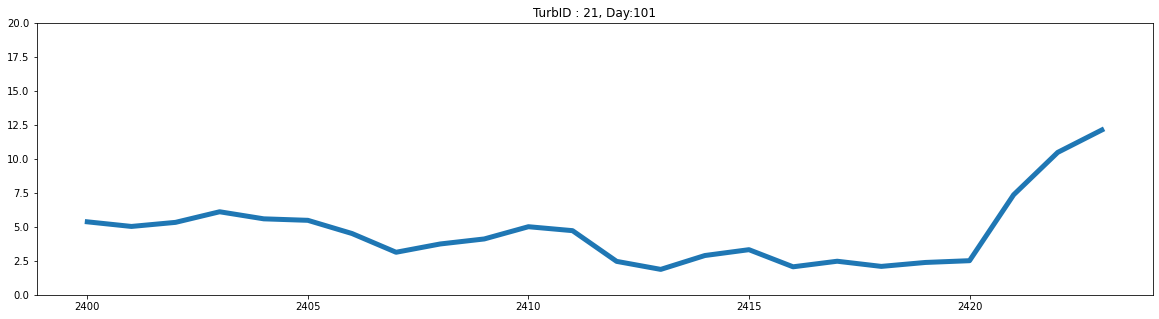

In [88]:
# Tmstamp 당 Patv 추세를 확인.
plot_data = my_df

plt.figure(figsize=(20, 5))
j = 101 # Day
#for i in range(1, 135): # TurbID
#    plt.plot(plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Patv'])
#    plt.xticks([])
plt.ylim([0,20])
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Wspd'], linewidth=5.0,
        label='real')
plt.title(f'TurbID : {k}, Day:{j}')




Text(0.5, 1.0, 'TurbID : 21, Day:61')

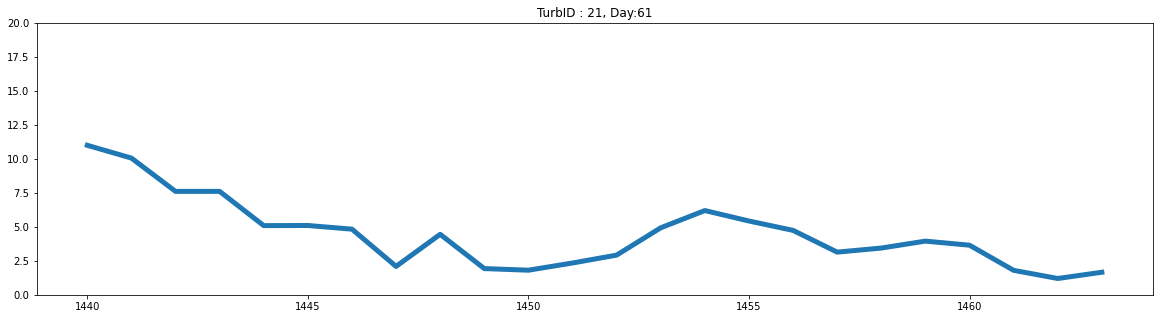

In [89]:
# Tmstamp 당 Patv 추세를 확인.
plot_data = my_df

plt.figure(figsize=(20, 5))
j = 61 # Day
#for i in range(1, 135): # TurbID
#    plt.plot(plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Patv'])
#    plt.xticks([])
plt.ylim([0,20])
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Wspd'], linewidth=5.0,
        label='real')
plt.title(f'TurbID : {k}, Day:{j}')




(0.0, 30.0)

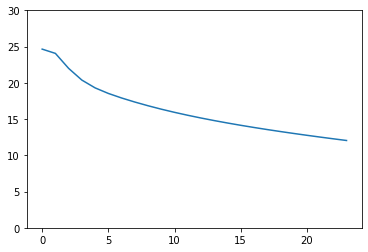

In [91]:
plt.plot(preds[:24])
plt.ylim([0,30])

(0.0, 20.0)

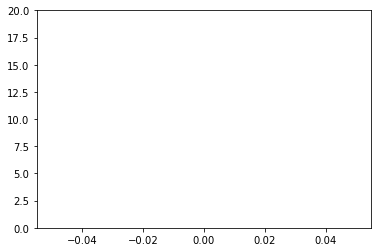

In [47]:
plt.plot(preds[24:24*2])
plt.ylim([0,20])

In [ ]:
sample_submission["Patv"] = preds
sample_submission.to_csv("./submit.csv", index = False)